<a href="https://colab.research.google.com/github/joacop01/Analisis-tiempo-frecuencia/blob/main/evaluating_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluting SAM for TF applications

## Setting Up SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/1sI8ccxI6OBXSp7rNQ42SWErLw3Kdk-Hp#scrollTo=072e25b8">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mbxdrift
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mbxdrift
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=dd25ae3931e1c3470d094e90303f2c2d5926b22d1f58b0a608396351ee384587
  Stored in directory: /tmp/pip-ephem-wheel-cache-1j6qk0x9/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-04-11 19:15:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78,

In [ ]:
!pip install mcsm_benchs

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python <3.11,>=3.8; 0.1.1 Requires-Python <3.11,>=3.8; 0.1.2 Requires-Python <3.11,>=3.8
ERROR: Could not find a version that satisfies the requirement mcsm_benchs (from versions: none)
ERROR: No matching distribution found for mcsm_benchs


## Importing necessary modules

In [ ]:
# Relevant modules
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sg
from scipy.fft import fft, ifft
from numpy import pi as pi

# SAM
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

### This function handles the dictionary of masks to display them later.

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def show_mask(mask, ax, random_color=False, color=None):
    """
    Muestra una máscara sobre un eje matplotlib.

    Args:
        mask (ndarray): Máscara binaria.
        ax (matplotlib.axes.Axes): Eje sobre el que dibujar la máscara.
        random_color (bool): Si es True, se elige un color aleatorio.
        color (list o ndarray): Color RGBA a usar. Si es None y random_color=False, se usa color azul por defecto.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color is None:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])  # azul por defecto

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)


In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# mask_generator = SamAutomaticMaskGenerator(sam)

### Some TF utilities

In [ ]:
import numpy as np
from numpy.fft import fft, ifft

# Función para obtener una ventana Gaussiana con el tamaño especificado
def get_gauss_window(Nfft, L, prec=1e-6):
    """
    Genera una ventana Gaussiana con un tamaño determinado.

    Args:
        Nfft (int): Número de puntos de la FFT.
        L (float): Parámetro de escala de la ventana Gaussiana.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
    """
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1
    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g

# Función para obtener una ventana Gaussiana redonda para la STFT
def get_round_window(Nfft, prec=1e-6):
    """
    Genera una ventana Gaussiana redonda, es decir, con el mismo soporte esencial
    en tiempo y frecuencia, para el cálculo de la Transformada de Fourier de Corto Tiempo (STFT).

    Args:
        Nfft (int): Número de puntos de la FFT.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
        L (float): La escala de la ventana Gaussiana, calculada como L = sqrt(Nfft).
    """
    L = np.sqrt(Nfft)
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1

    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g, L

# Función para calcular la STFT de una señal
def get_stft(x, window=None, t=None, Nfft=None):
    """
    Calcula la Transformada de Fourier de Tiempo Corto (STFT) de una señal.

    Args:
        x (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana para la STFT.
        t (ndarray, opcional): Los índices de tiempo.
        Nfft (int, opcional): Número de puntos para la FFT.

    Returns:
        tfr (ndarray): La STFT de la señal.
    """
    xrow = len(x)

    if t is None:
        t = np.arange(0, xrow)

    if Nfft is None:
        Nfft = 2 * xrow

    if window is None:
        window, _ = get_round_window(Nfft)

    tcol = len(t)
    hlength = np.floor(Nfft / 4)
    hlength = int(hlength + 1 - np.remainder(hlength, 2))

    hrow = len(window)

    assert np.remainder(hrow, 2) == 1

    Lh = (hrow - 1) // 2
    tfr = np.zeros((Nfft, tcol), dtype=complex)
    for icol in range(0, tcol):
        ti = t[icol]
        tau = np.arange(-np.min([np.round(Nfft / 2), Lh, ti]), np.min([np.round(Nfft / 2), Lh, xrow - ti])).astype(int)
        indices = np.remainder(Nfft + tau, Nfft).astype(int)
        tfr[indices, icol] = x[ti + tau] * np.conj(window[Lh + tau]) / np.linalg.norm(window[Lh + tau])

    tfr = fft(tfr, axis=0)
    return tfr

# Función para calcular la ISTFT (inversa de la STFT)
def get_istft(tfr, window=None, t=None):
    """
    Calcula la inversa de la STFT para obtener la señal original.

    Args:
        tfr (ndarray): La STFT de la señal.
        window (ndarray, opcional): La ventana utilizada.
        t (ndarray, opcional): Los índices de tiempo.

    Returns:
        x (ndarray): La señal reconstruida.
    """
    N, NbPoints = tfr.shape
    tcol = len(t)
    hrow = len(window)
    Lh = (hrow - 1) // 2
    window = window / np.linalg.norm(window)
    tfr = ifft(tfr, axis=0)

    x = np.zeros((tcol,), dtype=complex)
    for icol in range(0, tcol):
        valuestj = np.arange(np.max([1, icol - N / 2, icol - Lh]), np.min([tcol, icol + N / 2, icol + Lh])).astype(int)
        for tj in valuestj:
            tau = icol - tj
            indices = np.remainder(N + tau, N).astype(int)
            x[icol] = x[icol] + tfr[indices, tj] * window[Lh + tau]

        x[icol] = x[icol] / np.sum(np.abs(window[Lh + icol - valuestj]) ** 2)
    return x

# Función para calcular el espectrograma de una señal
def get_spectrogram(signal, window=None, Nfft=None, t=None, onesided=True):
    """
    Calcula el espectrograma de una señal utilizando una ventana dada.

    Args:
        signal (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana utilizada para la STFT.
        Nfft (int, opcional): Número de puntos de la FFT.
        t (ndarray, opcional): Los índices de tiempo.
        onesided (bool, opcional): Si es True, devuelve el espectrograma de un solo lado (frecuencias positivas).

    Returns:
        S (ndarray): El espectrograma de la señal.
        stft (ndarray): La STFT de la señal.
    """
    N = np.max(signal.shape)
    if Nfft is None:
        Nfft = 2 * N

    if window is None:
        window, _ = get_round_window(Nfft)

    if t is None:
        t = np.arange(0, N)

    stft = get_stft(signal, window=window, t=t, Nfft=Nfft)

    if onesided:
        S = np.abs(stft[0:Nfft // 2 + 1, :]) ** 2
    else:
        S = np.abs(stft) ** 2
    return S, stft

# Función para encontrar los ceros del espectrograma
def find_zeros_of_spectrogram(S, return_qz=False):
    """
    Encuentra los ceros en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de ceros.

    Returns:
        pos (ndarray): Las posiciones de los ceros en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2)) + np.inf
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = ((S <= np.roll(S, 1, 0)) &
                 (S <= np.roll(S, -1, 0)) &
                 (S <= np.roll(S, 1, 1)) &
                 (S <= np.roll(S, -1, 1)) &
                 (S <= np.roll(S, [-1, -1], [0, 1])) &
                 (S <= np.roll(S, [1, 1], [0, 1])) &
                 (S <= np.roll(S, [-1, 1], [0, 1])) &
                 (S <= np.roll(S, [1, -1], [0, 1])))
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para encontrar los máximos en el espectrograma
def find_max_of_spectrogram(S, return_qz=False):
    """
    Encuentra los máximos en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de máximos.

    Returns:
        pos (ndarray): Las posiciones de los máximos en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2))
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = (
            (S >= np.roll(S, 1, 0)) &
            (S >= np.roll(S, -1, 0)) &
            (S >= np.roll(S, 1, 1)) &
            (S >= np.roll(S, -1, 1)) &
            (S >= np.roll(S, [-1, -1], [0, 1])) &
            (S >= np.roll(S, [1, 1], [0, 1])) &
            (S >= np.roll(S, [-1, 1], [0, 1])) &
            (S >= np.roll(S, [1, -1], [0, 1]))
            )
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para calcular el histograma de ceros para una señal dada
def d2_histogram(signal, J=256, beta=1.0, Nfft=None):
    """
    Calcula el histograma de ceros para una señal dada con ruido añadido.

    Args:
        signal (ndarray): La señal de entrada.
        J (int, opcional): Número de muestras de ruido. Por defecto es 256.
        beta (float, opcional): Factor de escala para el ruido. Por defecto es 1.0.
        Nfft (int, opcional): Número de puntos de la FFT.

    Returns:
        hist (ndarray): El histograma de ceros.
    """
    N = len(signal)
    S, stft = get_spectrogram(signal, Nfft=Nfft)
    absFr = np.abs(np.real(stft))
    stdAlgEst = np.sqrt(2) * np.median(absFr) / 0.6745

    Qz = find_zeros_of_spectrogram(S, return_qz=True).astype(int)
    hist = np.zeros_like(Qz)

    for j in range(J - 1):
        noise = np.random.randn(N,)
        noisy_signal = signal + noise * beta * stdAlgEst
        S, _ = get_spectrogram(noisy_signal, Nfft=Nfft)
        Qz = find_zeros_of_spectrogram(S, return_qz=True)
        hist += Qz.astype(int)

    return hist

# Función para reconstruir una señal a partir de su STFT y una máscara
def reconstruct_signal_3(stft, mask, window=None):
    """
    Reconstruye una señal a partir de su STFT y una máscara.

    Args:
        stft (ndarray): La STFT de la señal.
        mask (ndarray): La máscara que se aplica a la STFT.
        window (ndarray, opcional): La ventana utilizada para la reconstrucción.

    Returns:
        xr (ndarray): La señal reconstruida.
    """

    mask_complete = np.zeros_like(stft)
    mask_complete[0:mask.shape[0], :] = mask
    mask_complete[mask.shape[0]::, :] = mask[-2:0:-1, :]
    xr = get_istft(stft * mask_complete, window=window, t=np.arange(0, stft.shape[1]))
    return xr



# Función para añadir ruido a una señal para obtener una relación señal-ruido (SNR) deseada
def add_snr(x, snr, complex_noise=False):
    """
    Añade ruido a una señal para obtener una relación señal-ruido (SNR) deseada.

    Args:
        x (ndarray): La señal de entrada.
        snr (float): La relación señal-ruido deseada en dB.
        complex_noise (bool, opcional): Si es True, el ruido será complejo (real + imaginario).

    Returns:
        x (ndarray): La señal con ruido añadido.
        n (ndarray): El ruido añadido.
    """
    N = len(x)
    x = x - np.mean(x)
    Px = np.sum(x ** 2)

    # Crear el ruido para la señal con el SNR dado:
    n = np.random.randn(N,)
    if complex_noise:
        n = n.astype(complex)
        n += 1j * np.random.randn(N,)

    Pn = np.sum(np.abs(n) ** 2, axis=0)  # Normalizar la varianza del ruido a 1.
    n = n / np.sqrt(Pn)
    Pn = Px * 10 ** (- snr / 10)  # Darle al ruido la varianza prescrita.
    n = n * np.sqrt(Pn)

    snr_out = 10 * np.log10(Px / Pn)
    print('snr_out:{}'.format(snr_out))
    return x + n, n


### Generating SAM and evaluating

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(sam)
#mask_generator_2 = SamAutomaticMaskGenerator(
#    model=sam,
#    points_per_side=32,
#    pred_iou_thresh=0.86,
#    stability_score_thresh=0.92,
#    crop_n_layers=1,
#    crop_n_points_downscale_factor=1,
#    min_mask_region_area=50,  # Requires open-cv to run post-processing
#)

In [ ]:
def sam_filtering(signal, Nfft=512):
    """
    Realiza un filtrado utilizando el espectrograma de la señal, seguido de la generación de una máscara.

    Args:
        signal (ndarray): La señal de entrada.
        Nfft (int, opcional): Número de puntos de la FFT para calcular el espectrograma. Por defecto es 512.

    Returns:
        tuple: Una tupla que contiene:
            - masks2 (ndarray): Máscara generada a partir de la imagen del espectrograma.
            - image (ndarray): Imagen RGB del espectrograma normalizado.
    """
    N = len(signal)

    # Calcula el espectrograma de la señal
    S, _ = get_spectrogram(signal, Nfft=Nfft)

    # Normaliza el espectrograma entre 0 y 255 para crear una imagen
    S = (S - np.min(S)) / (np.max(S) - np.min(S)) * 255

    # Crea una imagen RGB donde cada canal (Rojo, Verde, Azul) es el espectrograma normalizado
    image = np.zeros((S.shape[0], S.shape[1], 3), dtype=np.uint8)
    image[:, :, 0] = S.astype(np.uint8)
    image[:, :, 1] = S.astype(np.uint8)
    image[:, :, 2] = S.astype(np.uint8)

    # Genera la máscara basada en la imagen del espectrograma
    masks2 = mask_generator_2.generate(image)

    return masks2, image


In [ ]:
from sklearn.cluster import KMeans

def sam_filtering_2(signal, Nfft=512, input_point=None, input_label=None, thr=0):
    """
    Realiza un filtrado basado en un espectrograma de la señal, utilizando un predictor para generar una máscara
    y reconstruir la señal filtrada.

    Args:
        signal (ndarray): La señal de entrada.
        Nfft (int, opcional): Número de puntos de la FFT para calcular el espectrograma. Por defecto es 512.
        input_point (ndarray, opcional): Coordenadas de los puntos de entrada para el predictor. Si es None, se generan automáticamente.
        input_label (ndarray, opcional): Etiquetas de los puntos de entrada para el predictor. Si es None, se generan automáticamente.
        thr (float, opcional): Umbral para el espectrograma. Los valores menores a este umbral se ponen a 0.

    Returns:
        tuple: Una tupla con:
            - mask (ndarray): Máscara generada por el predictor.
            - image (ndarray): Imagen del espectrograma normalizado.
            - xr (ndarray): Señal reconstruida utilizando la máscara.
            - input_point (ndarray): Coordenadas de los puntos de entrada.
            - input_label (ndarray): Etiquetas de los puntos de entrada.
    """
    N = len(signal)

    # Obtiene la ventana redonda y su escala
    g, L = get_round_window(Nfft,)

    # Calcula el espectrograma de la señal
    S, stft = get_spectrogram(signal, window=g, Nfft=Nfft)

    # Aplica el umbral al espectrograma
    S[S < thr] = 0

    # Normaliza el espectrograma entre 0 y 255 para crear una imagen
    S = (S - np.min(S)) / (np.max(S) - np.min(S))
    image = np.zeros((S.shape[0], S.shape[1], 3), dtype=np.float32)
    image[:, :, 0] = S
    image[:, :, 1] = S
    image[:, :, 2] = S

    # Establece la imagen para el predictor
    predictor.set_image(image)

    if input_point is None:
        # Calcula un valor gamma basado en el espectrograma para detectar picos
        gamma = 3 * 2**0.5 * np.median(np.abs(np.real(stft[0:N//2+1, :]))) / 0.6745

        # Encuentra los máximos del espectrograma
        max_pos = find_max_of_spectrogram(np.abs(stft[0:N//2+1, :]), return_qz=True)
        a = max_pos
        b = np.abs(stft[0:N//2+1, :]) > gamma
        max_ind = np.logical_and(a, b)
        ind_max = np.array(np.where(max_ind)).T

        # --- Paso 2. Agrupar los máximos en 2 clusters (2 componentes) ---
        n_clusters = 2  # Se esperan 2 componentes
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels_max = kmeans.fit_predict(ind_max)

        # Separamos los puntos de máximos según su cluster
        comp1_points = ind_max[labels_max == 0]
        comp2_points = ind_max[labels_max == 1]

        # Encuentra los ceros del espectrograma
        min_pos = find_zeros_of_spectrogram(np.abs(stft[0:N//2+1, :]), return_qz=True)
        ind_min = np.array(np.where(min_pos)).T

        # Convertí todos a NumPy si no lo están ya
        comp1_points = np.array(comp1_points)
        comp2_points = np.array(comp2_points)
        ind_min = np.array(ind_min)

        # Determiná el tamaño mínimo común
        min_len = min(len(comp1_points), len(comp2_points), len(ind_min))

        # Muestrea aleatoriamente 'min_len' puntos de cada conjunto
        np.random.seed(42)  # Para reproducibilidad
        comp1_sampled = comp1_points[np.random.choice(len(comp1_points), min_len, replace=False)]
        comp2_sampled = comp2_points[np.random.choice(len(comp2_points), min_len, replace=False)]
        min_sampled = ind_min[np.random.choice(len(ind_min), min_len, replace=False)]

        input_points = torch.tensor([
            [comp1_sampled],
            [comp2_sampled],
            [min_sampled],
        ], device=predictor.device)

        transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
        input_labels = torch.tensor([
            [1],
            [1],
            [0],
        ], device=predictor.device)

        # Combina las posiciones de los máximos y los ceros
        #input_point = np.concatenate([ind_max[:, ::-1], ind_min[:, ::-1]], axis=0)
        #input_label = np.concatenate((np.array([1 for i in ind_max]), np.array([0 for i in ind_min])), axis=0)

    # Realiza la predicción con el predictor
    mask, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=False,
    )


    # Reconstruye la señal filtrada utilizando la máscara
    xr = []
    num_masks = mask.shape[0]

    for i in range(num_masks):
      xr.append(np.real(reconstruct_signal_3(stft, np.squeeze(mask[i]), window=g)))


    return mask, image, xr, input_point, input_label


Defining the signal

In [ ]:
N = 1024
tmin = int(N**0.5)
tmax = N-int(N**0.5)
fmin=0.07
fmax=0.43
fmid = 0.25
Nsub = tmax-tmin
tsub = np.arange(Nsub)


# Cosenoidal Chirp 1
omega1=1.5
a1=1.0,
f0=fmax-0.05,
a2=0.04
instf1 = f0 + a2*np.cos(2*pi*omega1*tsub/Nsub - pi*omega1)
phase1 = np.cumsum(instf1)
a1 = 1.0
x1 = a1*np.cos(2*pi*phase1)*sg.windows.tukey(Nsub,0.25)

# Cosenoidal Chirp 2
omega2=1.8
a1=1.0,
f0=fmid
a2=0.04
instf2 = f0 + a2*np.cos(2*pi*omega2*tsub/Nsub - pi*omega2)
phase2 = np.cumsum(instf2)
x2 = a1*np.cos(2*pi*phase2)*sg.windows.tukey(Nsub,0.25)

signal_noiseless = np.zeros((N,))
signal_noiseless[tmin:tmax] = x1+x2

# Graficar las señales
plt.figure(figsize=(10, 8))

# Subgráfico 1: Chirp 1
plt.subplot(3, 1, 1)
plt.plot(tsub, x1)
plt.title("Cosenoidal Chirp 1")
plt.xlabel("Muestras (Tiempo)")
plt.ylabel("Amplitud")

# Subgráfico 2: Chirp 2
plt.subplot(3, 1, 2)
plt.plot(tsub, x2)
plt.title("Cosenoidal Chirp 2")
plt.xlabel("Muestras (Tiempo)")
plt.ylabel("Amplitud")

# Subgráfico 3: Señal compuesta
plt.subplot(3, 1, 3)
plt.plot(np.arange(N), signal_noiseless)
plt.title("Señal Compuesta")
plt.xlabel("Muestras (Tiempo)")
plt.ylabel("Amplitud")

# Ajustar y mostrar
plt.tight_layout()
plt.show()

In [ ]:
signal, noise = add_snr(signal_noiseless,15)
plt.figure(figsize=(10, 8))
plt.plot(np.arange(N), signal_noiseless)
plt.title("Señal Compuesta con ruido gaussiano")
plt.xlabel("Muestras (Tiempo)")
plt.ylabel("Amplitud")

# Ajustar y mostrar
plt.tight_layout()
plt.show()





In [ ]:
masks_prompt, image2, xr, input_point, input_label = sam_filtering_2(signal)


AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
print(10*np.log10(np.sum(signal_noiseless**2)/np.sum((signal_noiseless-xr)**2)))
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(signal_noiseless[200:800],'k', linewidth=0.75)
ax.plot(xr[200:800], '--g', linewidth=0.75)

TypeError: 'NoneType' object is not subscriptable

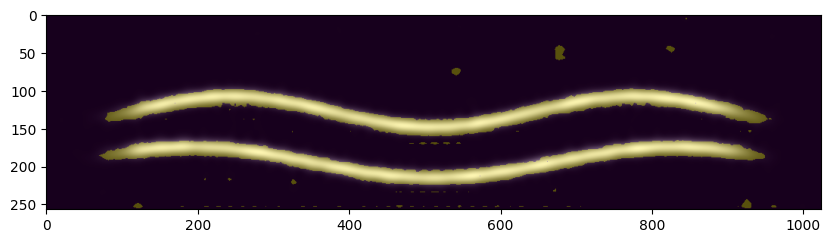

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image2)
plt.imshow(masks_prompt[0, :, :],alpha=0.35)


plt.plot(
    input_point[input_label == 1][:, 0],
    input_point[input_label == 1][:, 1],
    'ro',  # 'y' es amarillo, 'o' es marcador circular
    label='Máximos'
)

# Puntos con etiqueta 0 (mínimos, en azul)
plt.plot(
    input_point[input_label == 0][:, 0],
    input_point[input_label == 0][:, 1],
    'bo',  # 'b' es azul, 'o' es marcador circular
    label='Mínimos'
)

plt.legend()
plt.title("Puntos Máximos y Mínimos")
plt.show()



# Denoising Performance

In [ ]:
SNRs = [snr for snr in range(-20,25,5)]
reps = 50
QRF = np.zeros((reps,len(SNRs)))

all_signals = [[None for _ in SNRs] for _ in range(reps)]
all_images  = [[None for _ in SNRs] for _ in range(reps)]
all_masks  = [[None for _ in SNRs] for _ in range(reps)]

def qrf(x,xhat):
  return 10*np.log10(np.sum(x**2)/np.sum((x-xhat)**2))

for j in range(reps):
    print(j)
    for i,snr in enumerate(SNRs):
        signal, noise = add_snr(signal_noiseless,snr)
        mask, image, s_r, input_point, input_label = sam_filtering_2(signal, Nfft=N,)
        QRF[j,i] = qrf(signal_noiseless,s_r)


        all_signals[j][i] = s_r
        all_images[j][i] = image
        all_masks [j][i] = mask


0
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
1
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
2
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
3
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
4
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
5
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
6
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:4.999999999999999
snr_out:9.9999999999999

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_QRF = np.mean(QRF, axis=0)  # Promedio de QRF sobre las 50 repeticiones
std_QRF = np.std(QRF, axis=0)  # Desviación estándar para ver la dispersión

plt.figure(figsize=(8,5))
plt.errorbar(SNRs, mean_QRF, yerr=std_QRF, fmt='-o', capsize=5, label="QRF promedio")
plt.xlabel("SNR (dB)")
plt.ylabel("QRF (dB)")
plt.title("Calidad de reconstrucción vs. SNR")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
N = len(signal)
thr = 0

# Obtiene la ventana redonda y su escala
g, L = get_round_window(Nfft = N,)

# Calcula el espectrograma de la señal
S, stft = get_spectrogram(signal, window=g, Nfft=N)

# Aplica el umbral al espectrograma
S[S < thr] = 0

# Normaliza el espectrograma entre 0 y 255 para crear una imagen
S = (S - np.min(S)) / (np.max(S) - np.min(S)) * 255
image = np.zeros((S.shape[0], S.shape[1], 3), dtype=np.uint8)
image[:, :, 0] = S.astype(np.uint8)
image[:, :, 1] = S.astype(np.uint8)
image[:, :, 2] = S.astype(np.uint8)


In [ ]:
i = 10
j = 4

mascara = all_masks[i][j]

plt.figure(figsize=(10,10))
plt.imshow(all_images[i][j])
plt.imshow(mascara[0,:,:], alpha=0.35)
#plt.imshow(masks_prompt,alpha=0.35)
plt.axis('off')
plt.show()

In [ ]:
import os

# Crear la carpeta si no existe
os.makedirs("imagenes", exist_ok=True)

In [ ]:
!pwd

In [ ]:
import os
import cv2
import numpy as np


ruta_guardado = "/content/drive/My Drive/SAM/imagenes/"
ruta_mascaras = "/content/drive/My Drive/SAM/mascaras/"
ruta_senales = "/content/drive/My Drive/SAM/senales/"

os.makedirs(ruta_guardado, exist_ok=True)
os.makedirs(ruta_mascaras, exist_ok=True)
os.makedirs(ruta_senales, exist_ok=True)

for i in range(50):
    for j in range(9):
        nombre_archivo = f"imagen_{i}_{j}.png"

        # Guarda la imagen original
        cv2.imwrite(ruta_guardado + nombre_archivo, all_images[i][j])

        # Guarda el array booleano en un archivo .npy
        np.save(ruta_mascaras + f"mascara_{i}_{j}.npy", all_masks[i][j])

        np.save(ruta_senales + f"senal_{i}_{j}.npy", all_signals[i][j])




In [ ]:
print(10*np.log10(np.sum(signal_noiseless**2)/np.sum((signal_noiseless-all_signals[0][0])**2)))
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(signal_noiseless[200:800],'k', linewidth=0.75)
ax.plot(all_signals[i][j][200:800], '--g', linewidth=0.75)

In [ ]:
r = np.corrcoef(signal_noiseless, all_signals[i][j])[0, 1]

print(f"Coeficiente de correlación de Pearson: {r:.4f}")

Coeficiente de correlación de Pearson: 0.9477


In [ ]:
import cv2

# Inicializar la matriz de imágenes (50 filas x 9 columnas)
matriz_imagenes = []
ruta_imagenes = "/content/drive/My Drive/SAM/imagenes/"
ruta_mascaras = "/content/drive/My Drive/SAM/mascaras/"
ruta_senales = "/content/drive/My Drive/SAM/senales/"

for i in range(50):
    fila = []  # Cada fila de la matriz
    for j in range(9):
        # Define el nombre del archivo según el patrón utilizado al guardarlo
        nombre_archivo = f"imagen_{i}_{j}.png"
        # Lee la imagen; asegúrate de que la ruta sea correcta
        imagen = cv2.imread(ruta_imagenes+nombre_archivo)
        if imagen is None:
            print(f"Advertencia: No se pudo cargar {nombre_archivo}")
        fila.append(imagen)
    matriz_imagenes.append(fila)



In [ ]:
import numpy as np
import os

# Ruta donde se guardaron las máscaras
ruta_mascaras = "/content/drive/My Drive/SAM/mascaras/"

# Inicializar la matriz de máscaras (50 filas x 9 columnas)
matriz_mascaras = []

for i in range(50):
    fila = []
    for j in range(9):
        nombre_mascara = f"mascara_{i}_{j}.npy"
        ruta_completa = os.path.join(ruta_mascaras, nombre_mascara)
        # Verifica si el archivo existe
        if os.path.exists(ruta_completa):
            mascara = np.load(ruta_completa)
            fila.append(mascara)
        else:
            print(f"No se encontró el archivo {nombre_mascara}")
            fila.append(None)
    matriz_mascaras.append(fila)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os

# Ruta donde se guardaron las señales
ruta_senales = "/content/drive/My Drive/SAM/senales/"

# Inicializar la matriz de señales (50 filas x 9 columnas)
matriz_senales = []

for i in range(50):
    fila = []
    for j in range(9):
        nombre_senal = f"senal_{i}_{j}.npy"
        ruta_completa = os.path.join(ruta_senales, nombre_senal)
        if os.path.exists(ruta_completa):
            senal = np.load(ruta_completa)
            fila.append(senal)
        else:
            print(f"No se encontró el archivo {nombre_senal}")
            fila.append(None)
    matriz_senales.append(fila)


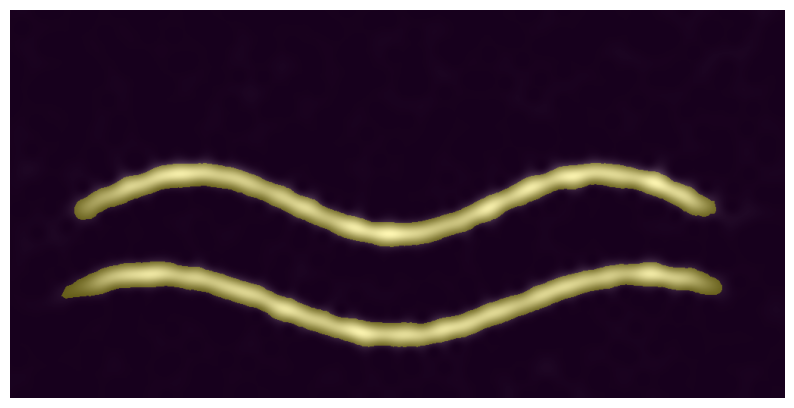

In [ ]:
i = 10
j = 6

mascara = matriz_mascaras[i][j]

plt.figure(figsize=(10,10))
plt.imshow(matriz_imagenes[i][j])
plt.imshow(mascara[0,:,:], alpha=0.35)
#plt.imshow(masks_prompt,alpha=0.35)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

# Suponiendo que 'matriz_senales' ya fue cargada y 'senal_sin_ruido' está definida:
# Creamos una matriz para almacenar los coeficientes (50 filas x 9 columnas)
coef_corr = np.zeros((50, 9))
QRF = np.zeros((reps,len(SNRs)))

for i in range(50):
    for j in range(9):
        # Aplanamos ambas señales en caso de que sean arrays multidimensionales
        sr = matriz_senales[i][j]

        # Calcular la matriz de correlación
        corr_matrix = np.corrcoef(sr, signal_noiseless)
        # Extraemos el coeficiente de correlación (entre 0 y 1, en términos absolutos o no)
        coef_corr[i, j] = corr_matrix[0, 1]
        QRF[i,j] = qrf(signal_noiseless,sr)

# Calcula la media y la desviación estándar a lo largo del eje 0 (50 repeticiones)
mean_corr = np.mean(coef_corr, axis=0)
std_corr = np.std(coef_corr, axis=0)



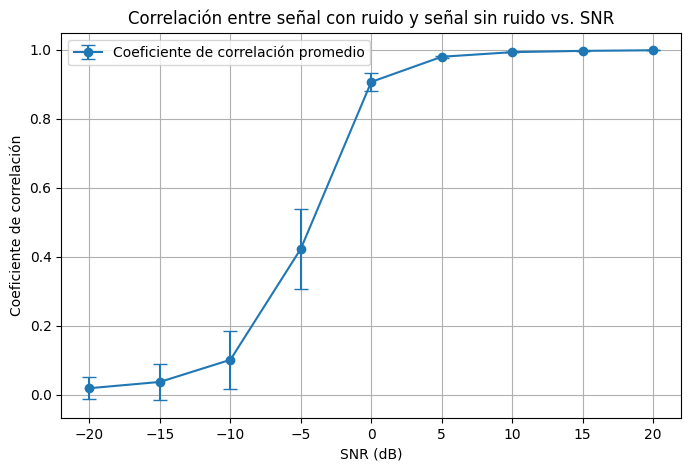

In [ ]:
import matplotlib.pyplot as plt


SNRs = [snr for snr in range(-20,25,5)]

plt.figure(figsize=(8, 5))
plt.errorbar(SNRs, mean_corr, yerr=std_corr, fmt='-o', capsize=5, label="Coeficiente de correlación promedio")
plt.xlabel("SNR (dB)")
plt.ylabel("Coeficiente de correlación")
plt.title("Correlación entre señal con ruido y señal sin ruido vs. SNR")
plt.grid(True)
plt.legend()
plt.show()


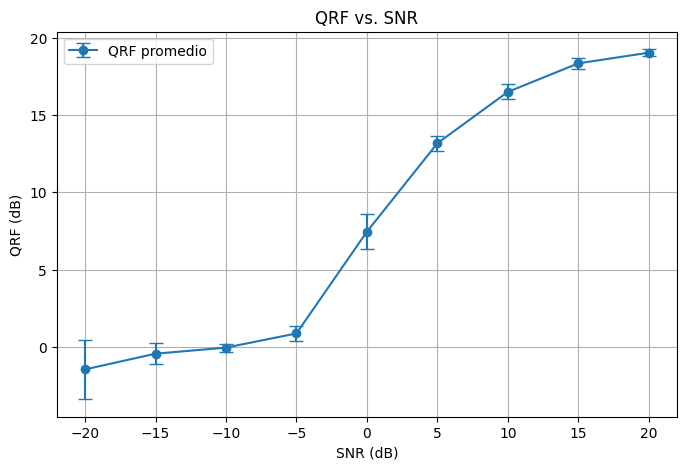

In [ ]:
mean_QRF = np.mean(QRF, axis=0)  # Promedio de QRF sobre las 50 repeticiones
std_QRF = np.std(QRF, axis=0)  # Desviación estándar para ver la dispersión

plt.figure(figsize=(8,5))
plt.errorbar(SNRs, mean_QRF, yerr=std_QRF, fmt='-o', capsize=5, label="QRF promedio")
plt.xlabel("SNR (dB)")
plt.ylabel("QRF (dB)")
plt.title("QRF vs. SNR")
plt.grid(True)
plt.legend()
plt.show()